# How to Find the Optimal Location for a Single Virtual Fence Base Station

## Requirements

This Jupyter Notebook is intended to be run inside of ArcGIS Pro with the Spatial Analysis extension/license. It is not intended to be run in a Jupyter Notebook outside of ArcGIS Pro. If you are not familiar with the ArcGIS Pro ArcPy package, please view the [What is ArcPy?](https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/what-is-arcpy-.htm).

License Requirements:
    ArcGIS Pro >3.0
    Spatial Analyst Extension

You must have ArcGIS Pro installed on your computer to run this notebook, and you must have the Spatial Analyst extension enabled.

## How To Open This Notebook in ArcGIS Pro

1. Open ArcGIS Pro and create a new project.

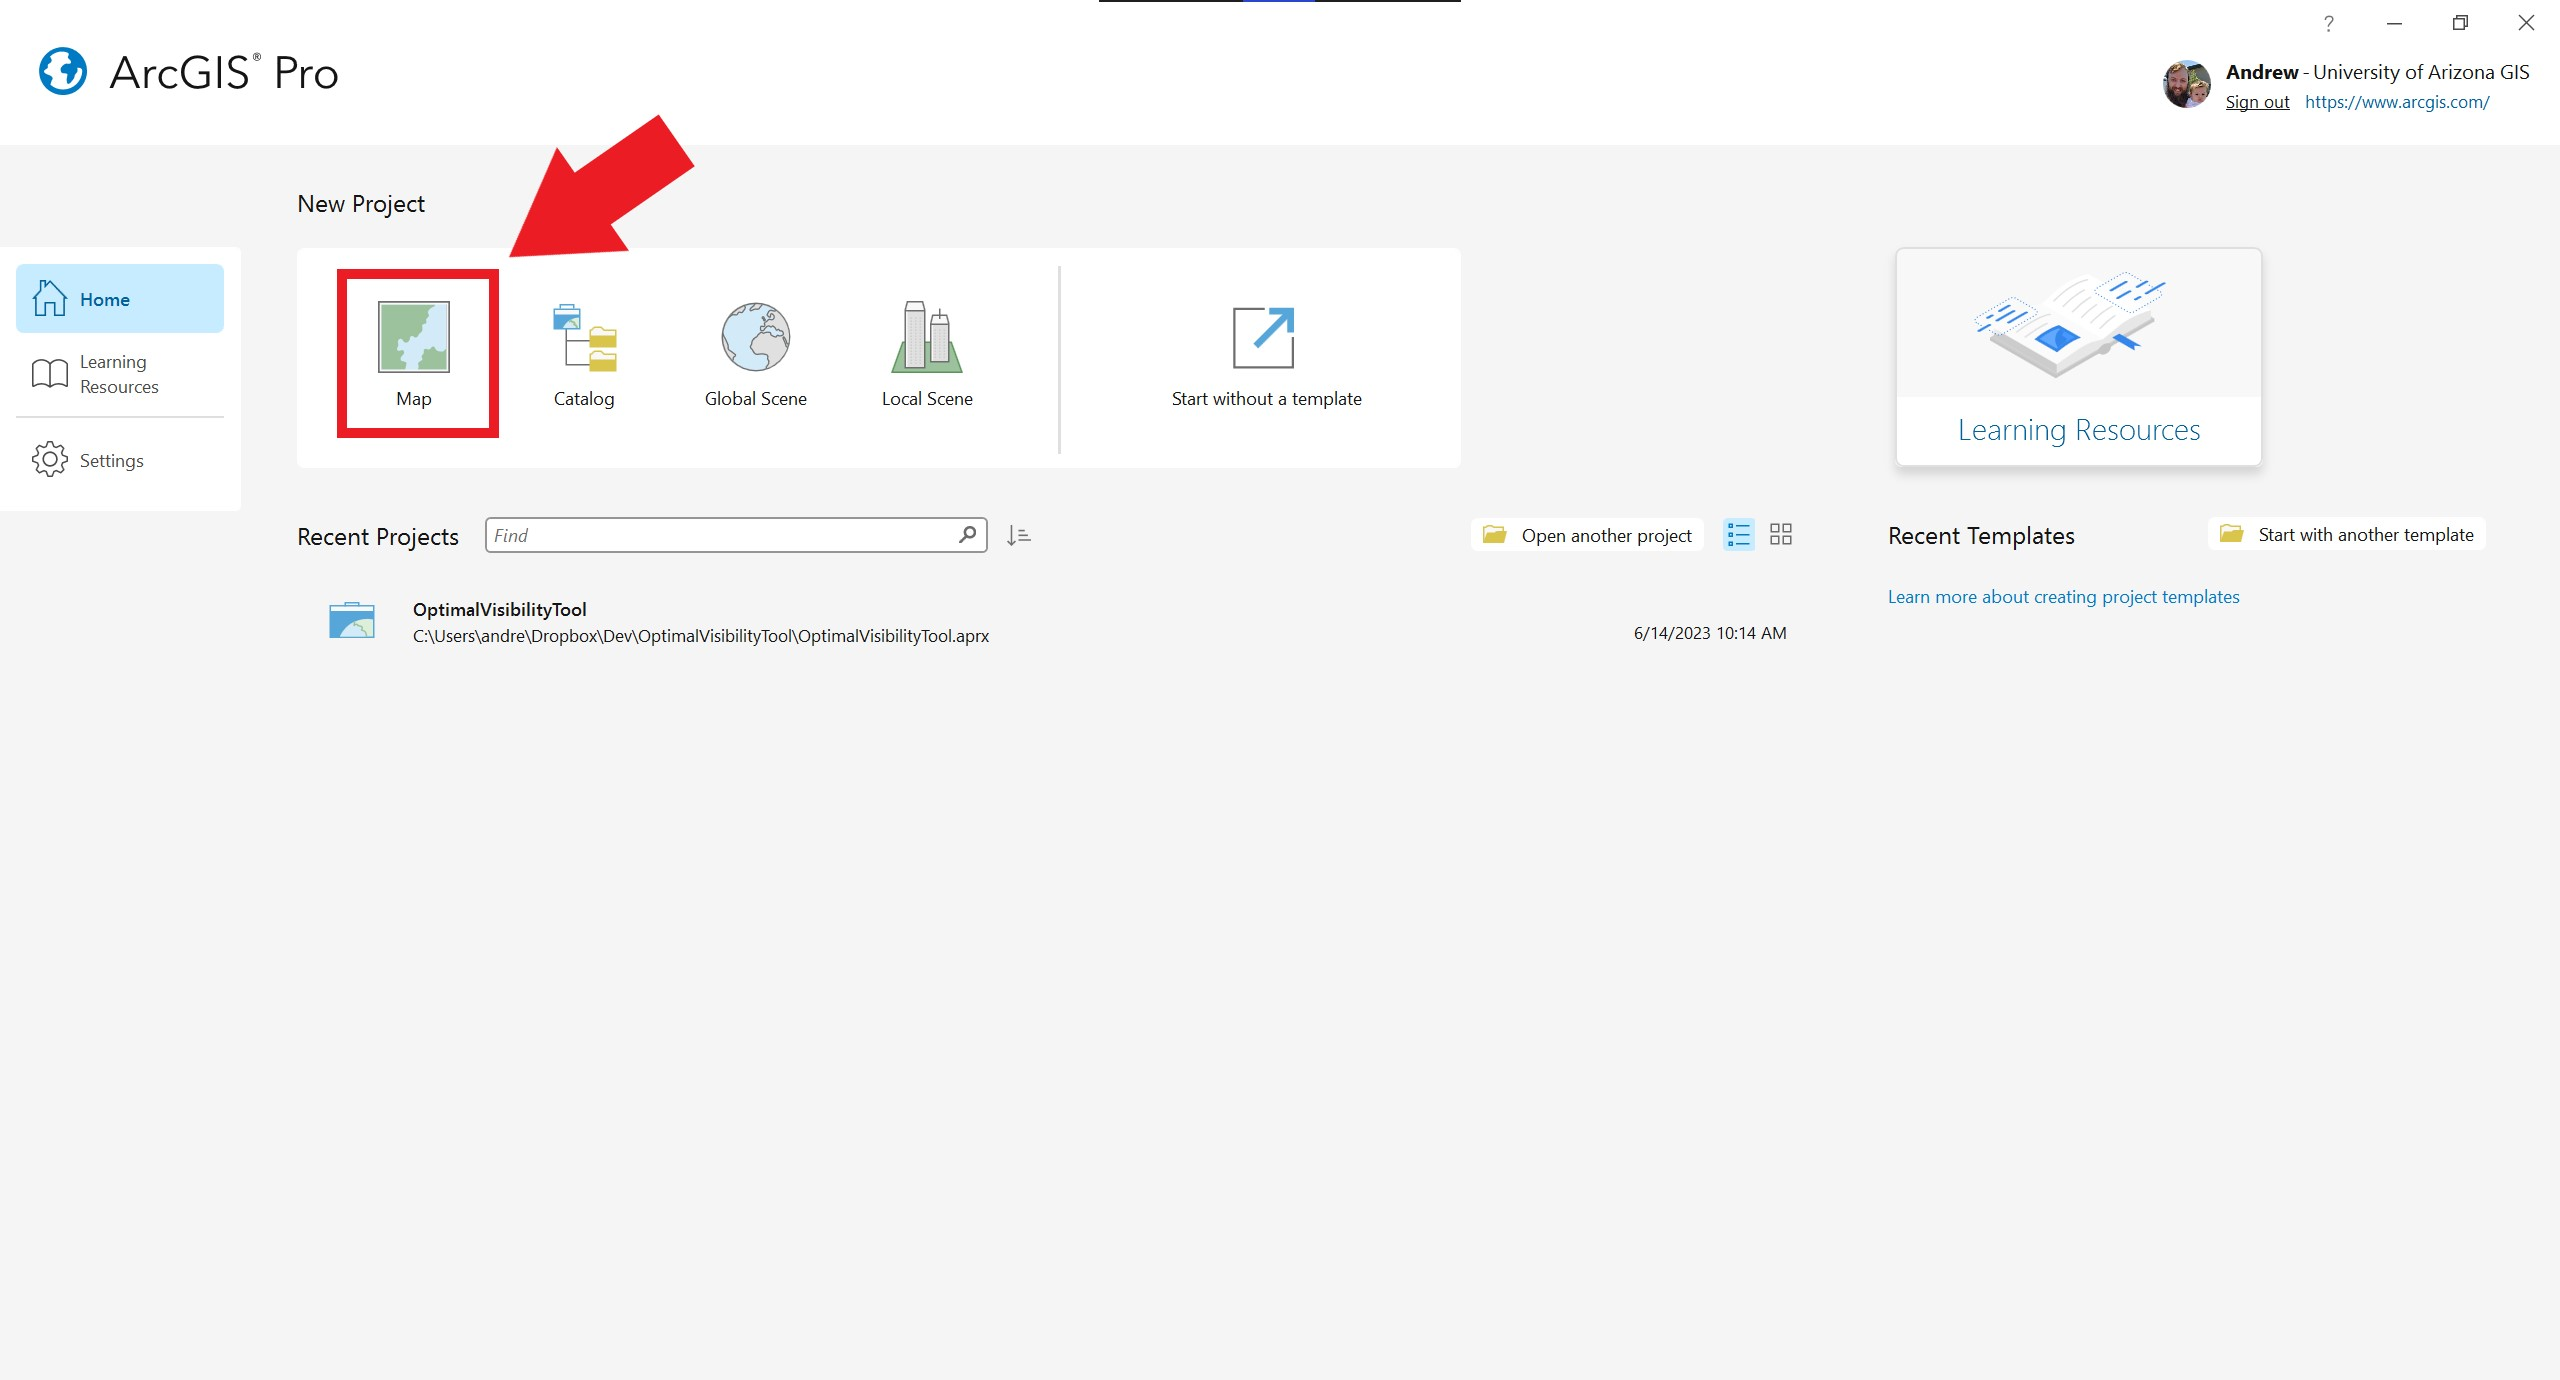

2. Under the "Catalog" pane on the right-side of the Map screen, under the "Project" tab, double-click on "Folders" to expand the ArcGIS project folder. Then double-click on "Notebooks" to open the Notebooks folder.

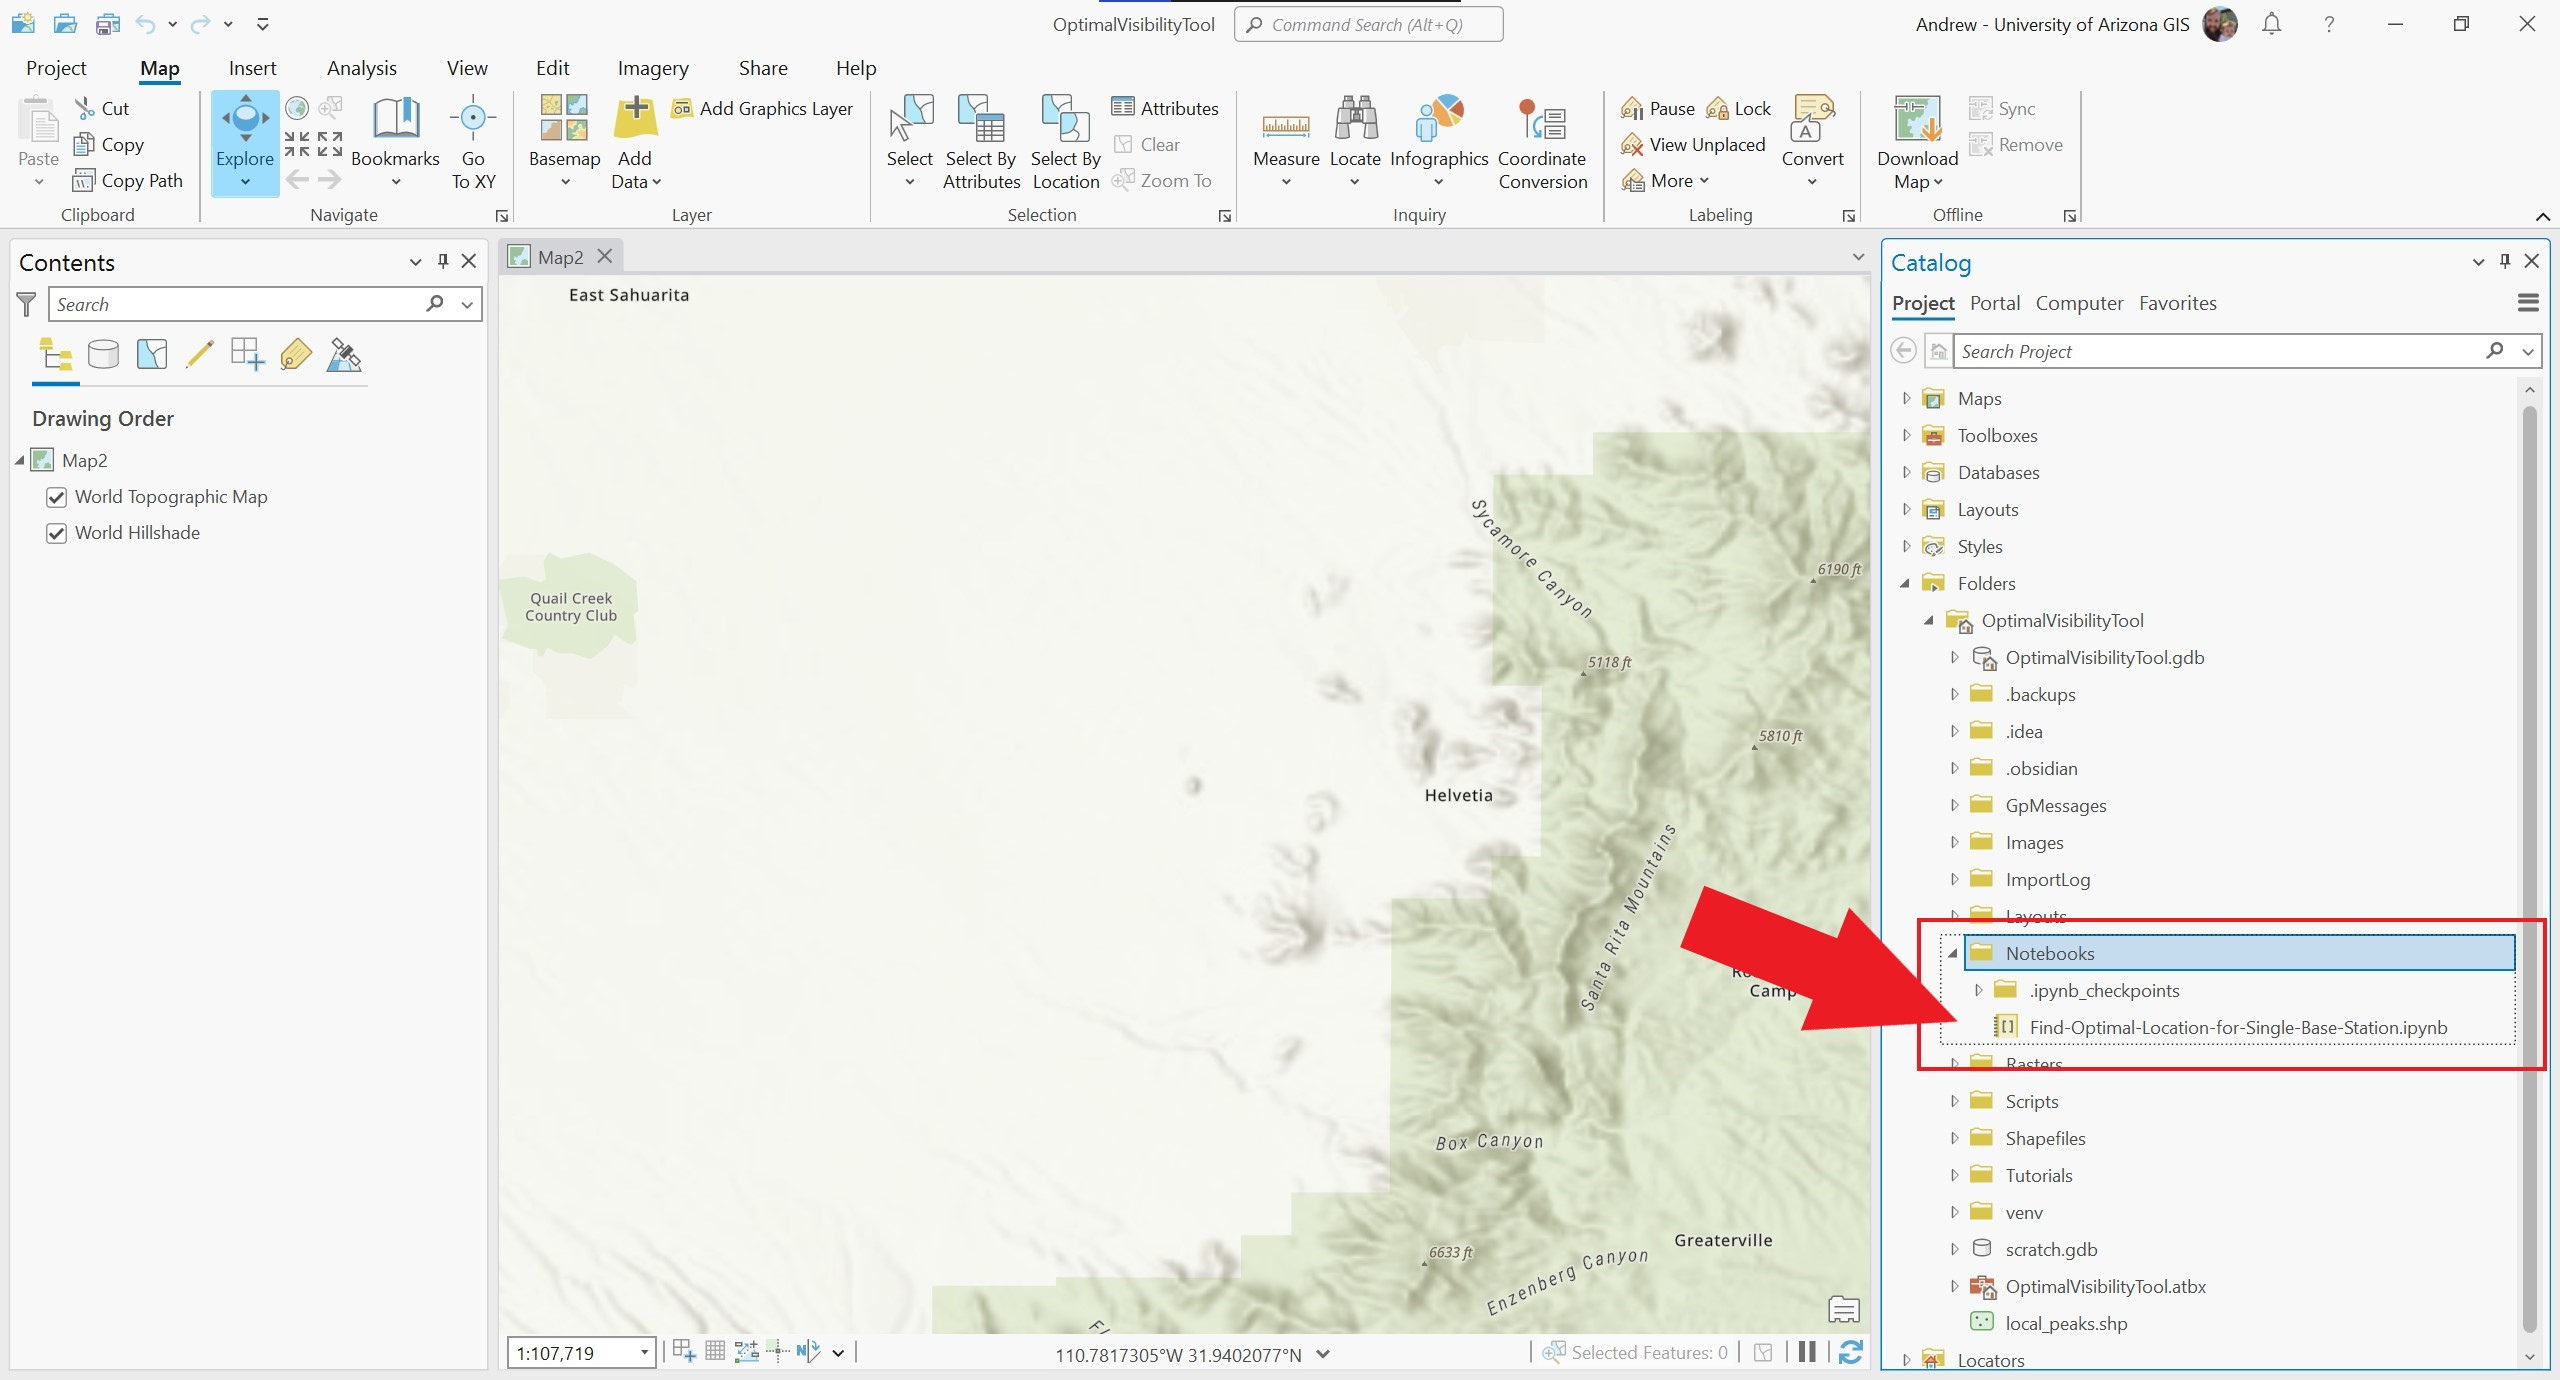

3. Double-click on the Jupyter notebook file you want to open within the "Notebooks" folder. In this case, we want to open the `Find-Optimal-Location-for-Single-Base-Station.ipynb` file.

4. The Jupyter Notebook will open in a new tab in ArcGIS Pro. You can now run the notebook.

## How to Run This Analysis in ArcGIS Pro

Now that you've opened the Jupyter Notebook in ArcGIS Pro, you will need to edit some of the lines of code to setup this notebook to run on your computer.

In [8]:
# import required packages
import arcpy
from arcpy import env
from arcpy.sa import *
import csv
import pandas as pd
import os

In [9]:
# Set ArcPy workspace - edit this line with the path to your ArcGIS project folder
arcpy.env.workspace = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool"

# Allow ArcPy to overwrite previous outputs
# Prevents a file permission error if you re-run this notebook multiple times
arcpy.env.overwriteOutput = True

View [HowToFindFilePaths.md](https://github.com/lilymcmullen/OptimalVisibilityTool/blob/master/Tutorials/HowToFindFilePaths.md) on GitHub for help with file paths.

In [10]:
# Set your Python working directory - edit this line with the path to your ArcGIS project folder
os.chdir(r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool")

# View your current working directory to check the location is correct
cwd = os.getcwd()
print(cwd)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool


In [11]:
# Edit this line with the path to your raster folder
raster_folder = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters"
print(raster_folder)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters


In [12]:
# Edit this line with the path to your area's DEM (digital elevation model)
input_raster = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\SRER.tif"

View [HowToFindYourDEM.md](https://github.com/lilymcmullen/OptimalVisibilityTool/blob/master/Tutorials/HowToFindYourDEM.md) on GitHub for help with finding a DEM for your area.

In [13]:
# Edit this line with a path to the shapefile of your area's boundaries
boundary_shapefile = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Shapefiles\srerboundary\bounds.shp"

In [14]:
# Crop your DEM by your area's boundary shapefile
# Constrains the analysis to only consider the area within your boundary shapefile
cropped_raster = ExtractByMask(input_raster, boundary_shapefile)

# Save the cropped raster to a .tif file
cropped_raster.save(
    os.path.join(raster_folder, "cropped_raster.tif")
    )

You can switch to the "Map" tab to view the cropped raster.

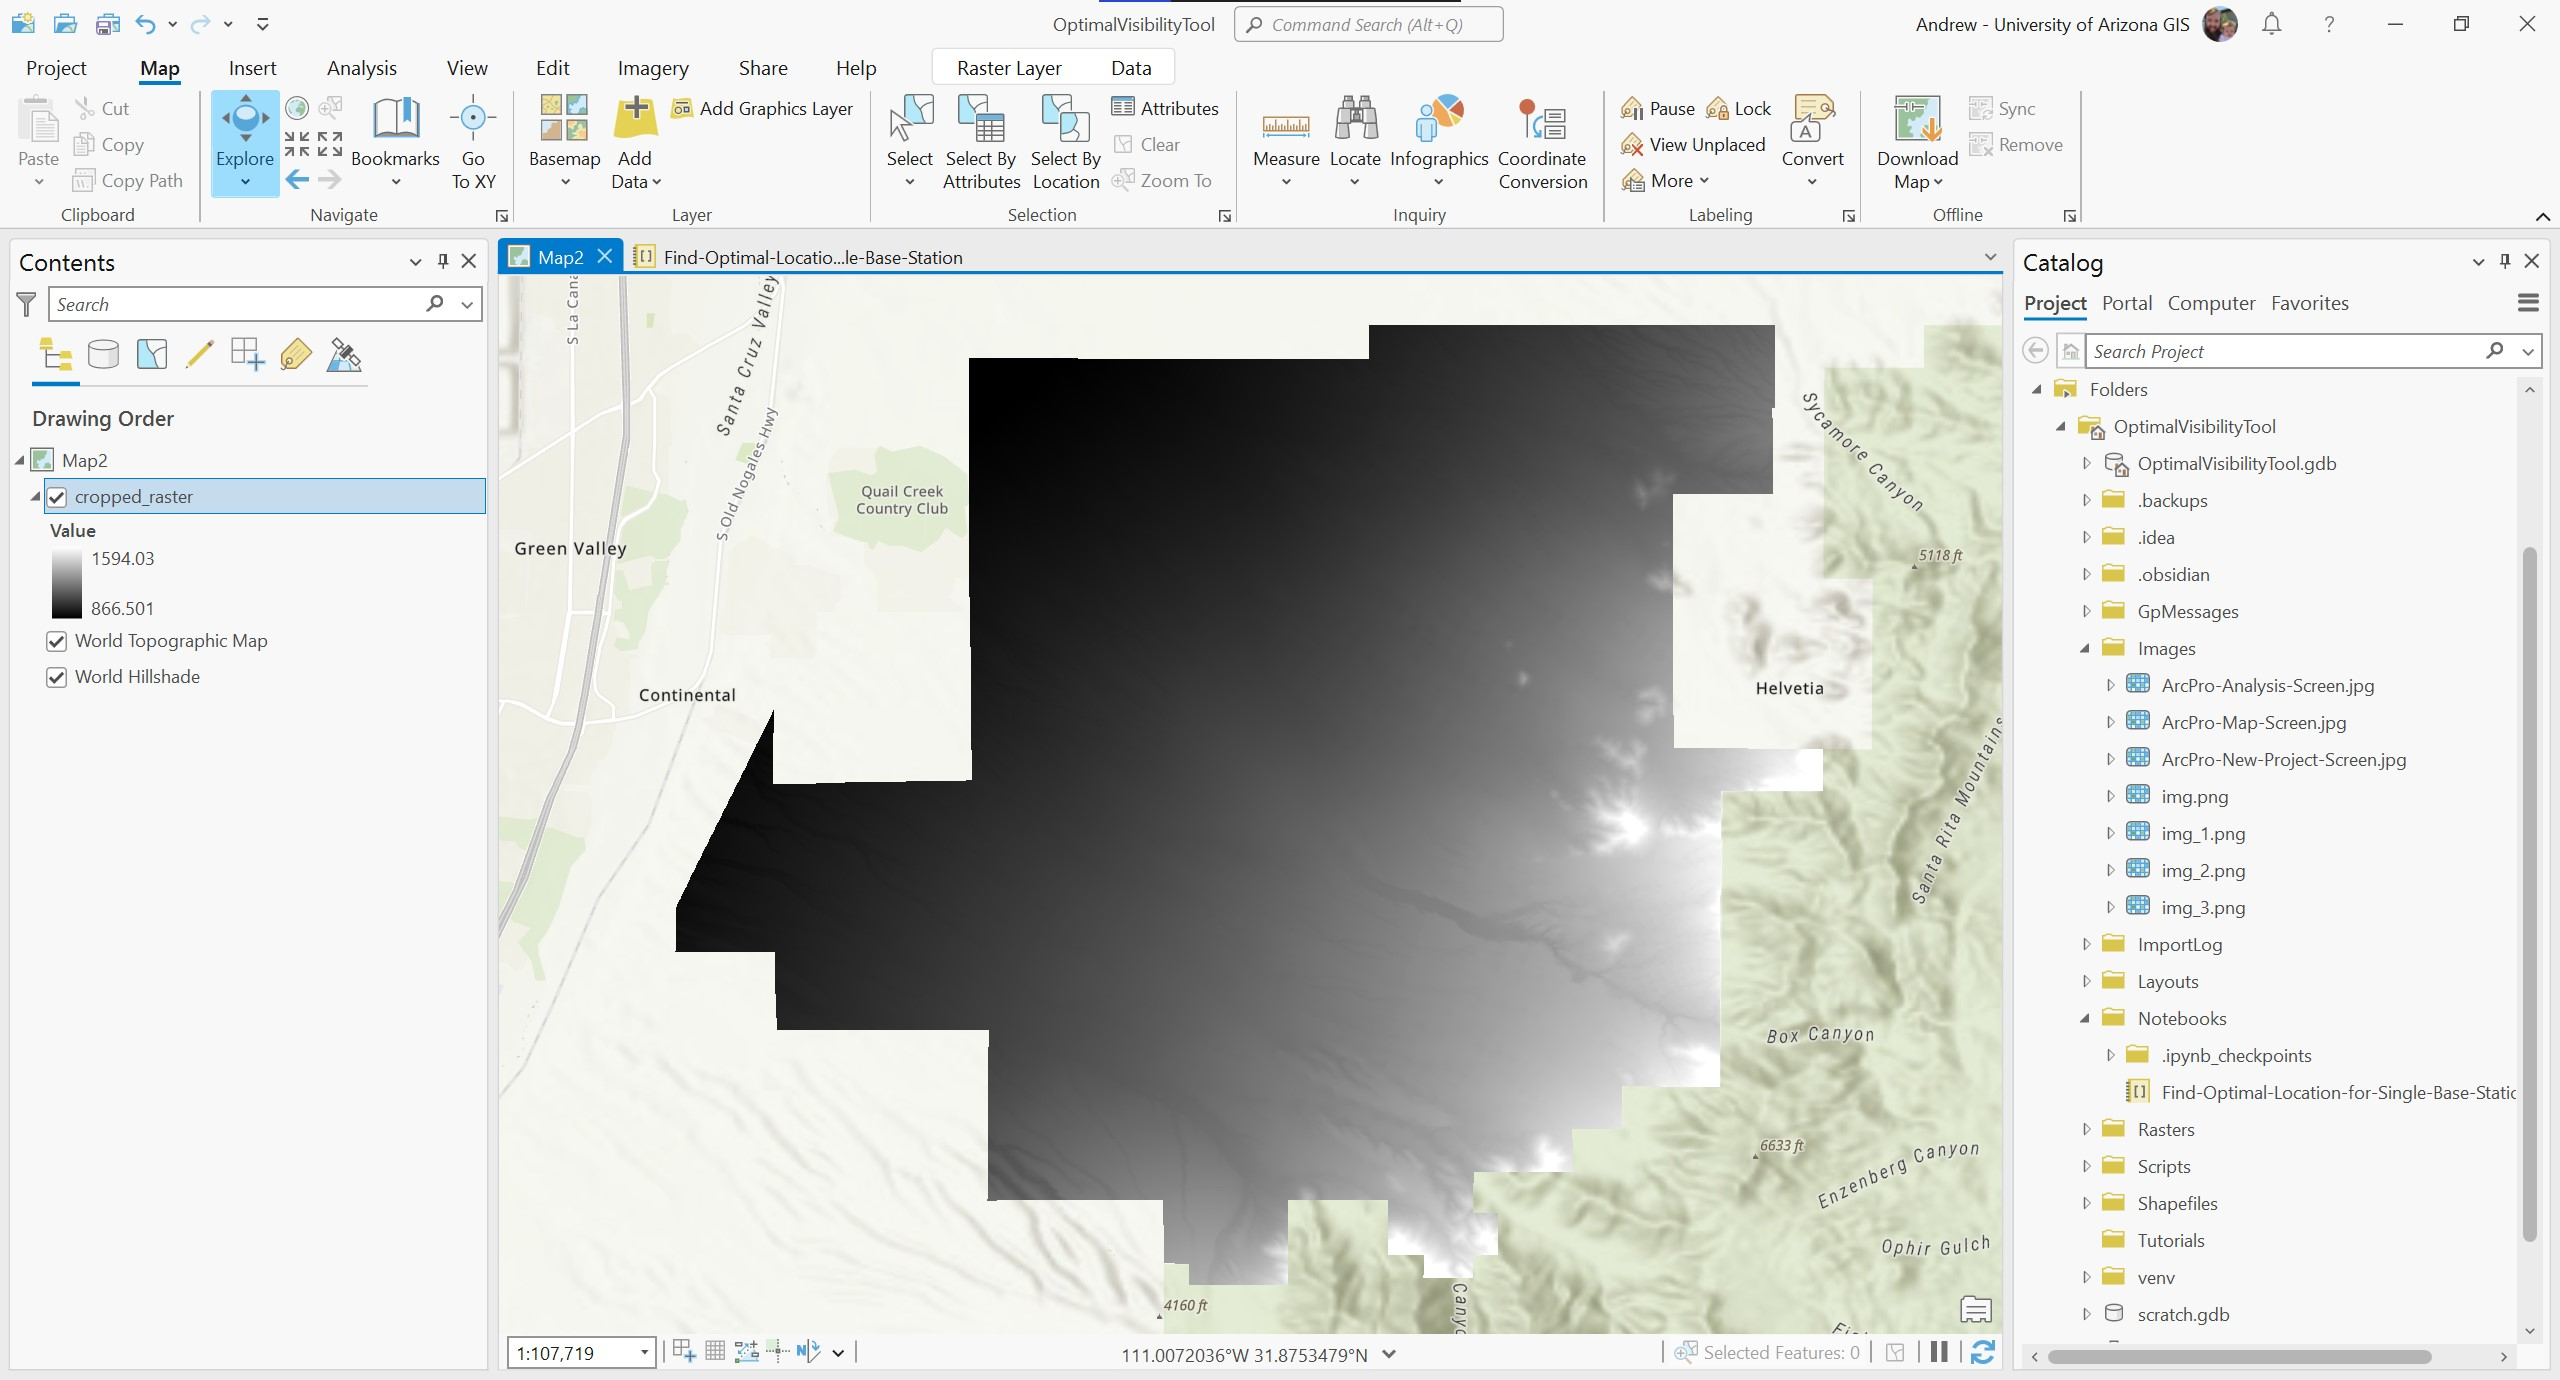

In [15]:
# Find local peaks within the cropped raster
# We will use these peaks to analyze as potential placements for base stations
# Default is 5 points, but set higher to consider more points, and lower for faster processing time
local_peaks = arcpy.defense.FindLocalPeaksValleys(
    cropped_raster, 
    "local_peaks", 
    "PEAKS", 
    5)

You can switch to the "Map" tab to view the local peaks that we will analyse as potential placements for virtual fence base stations.

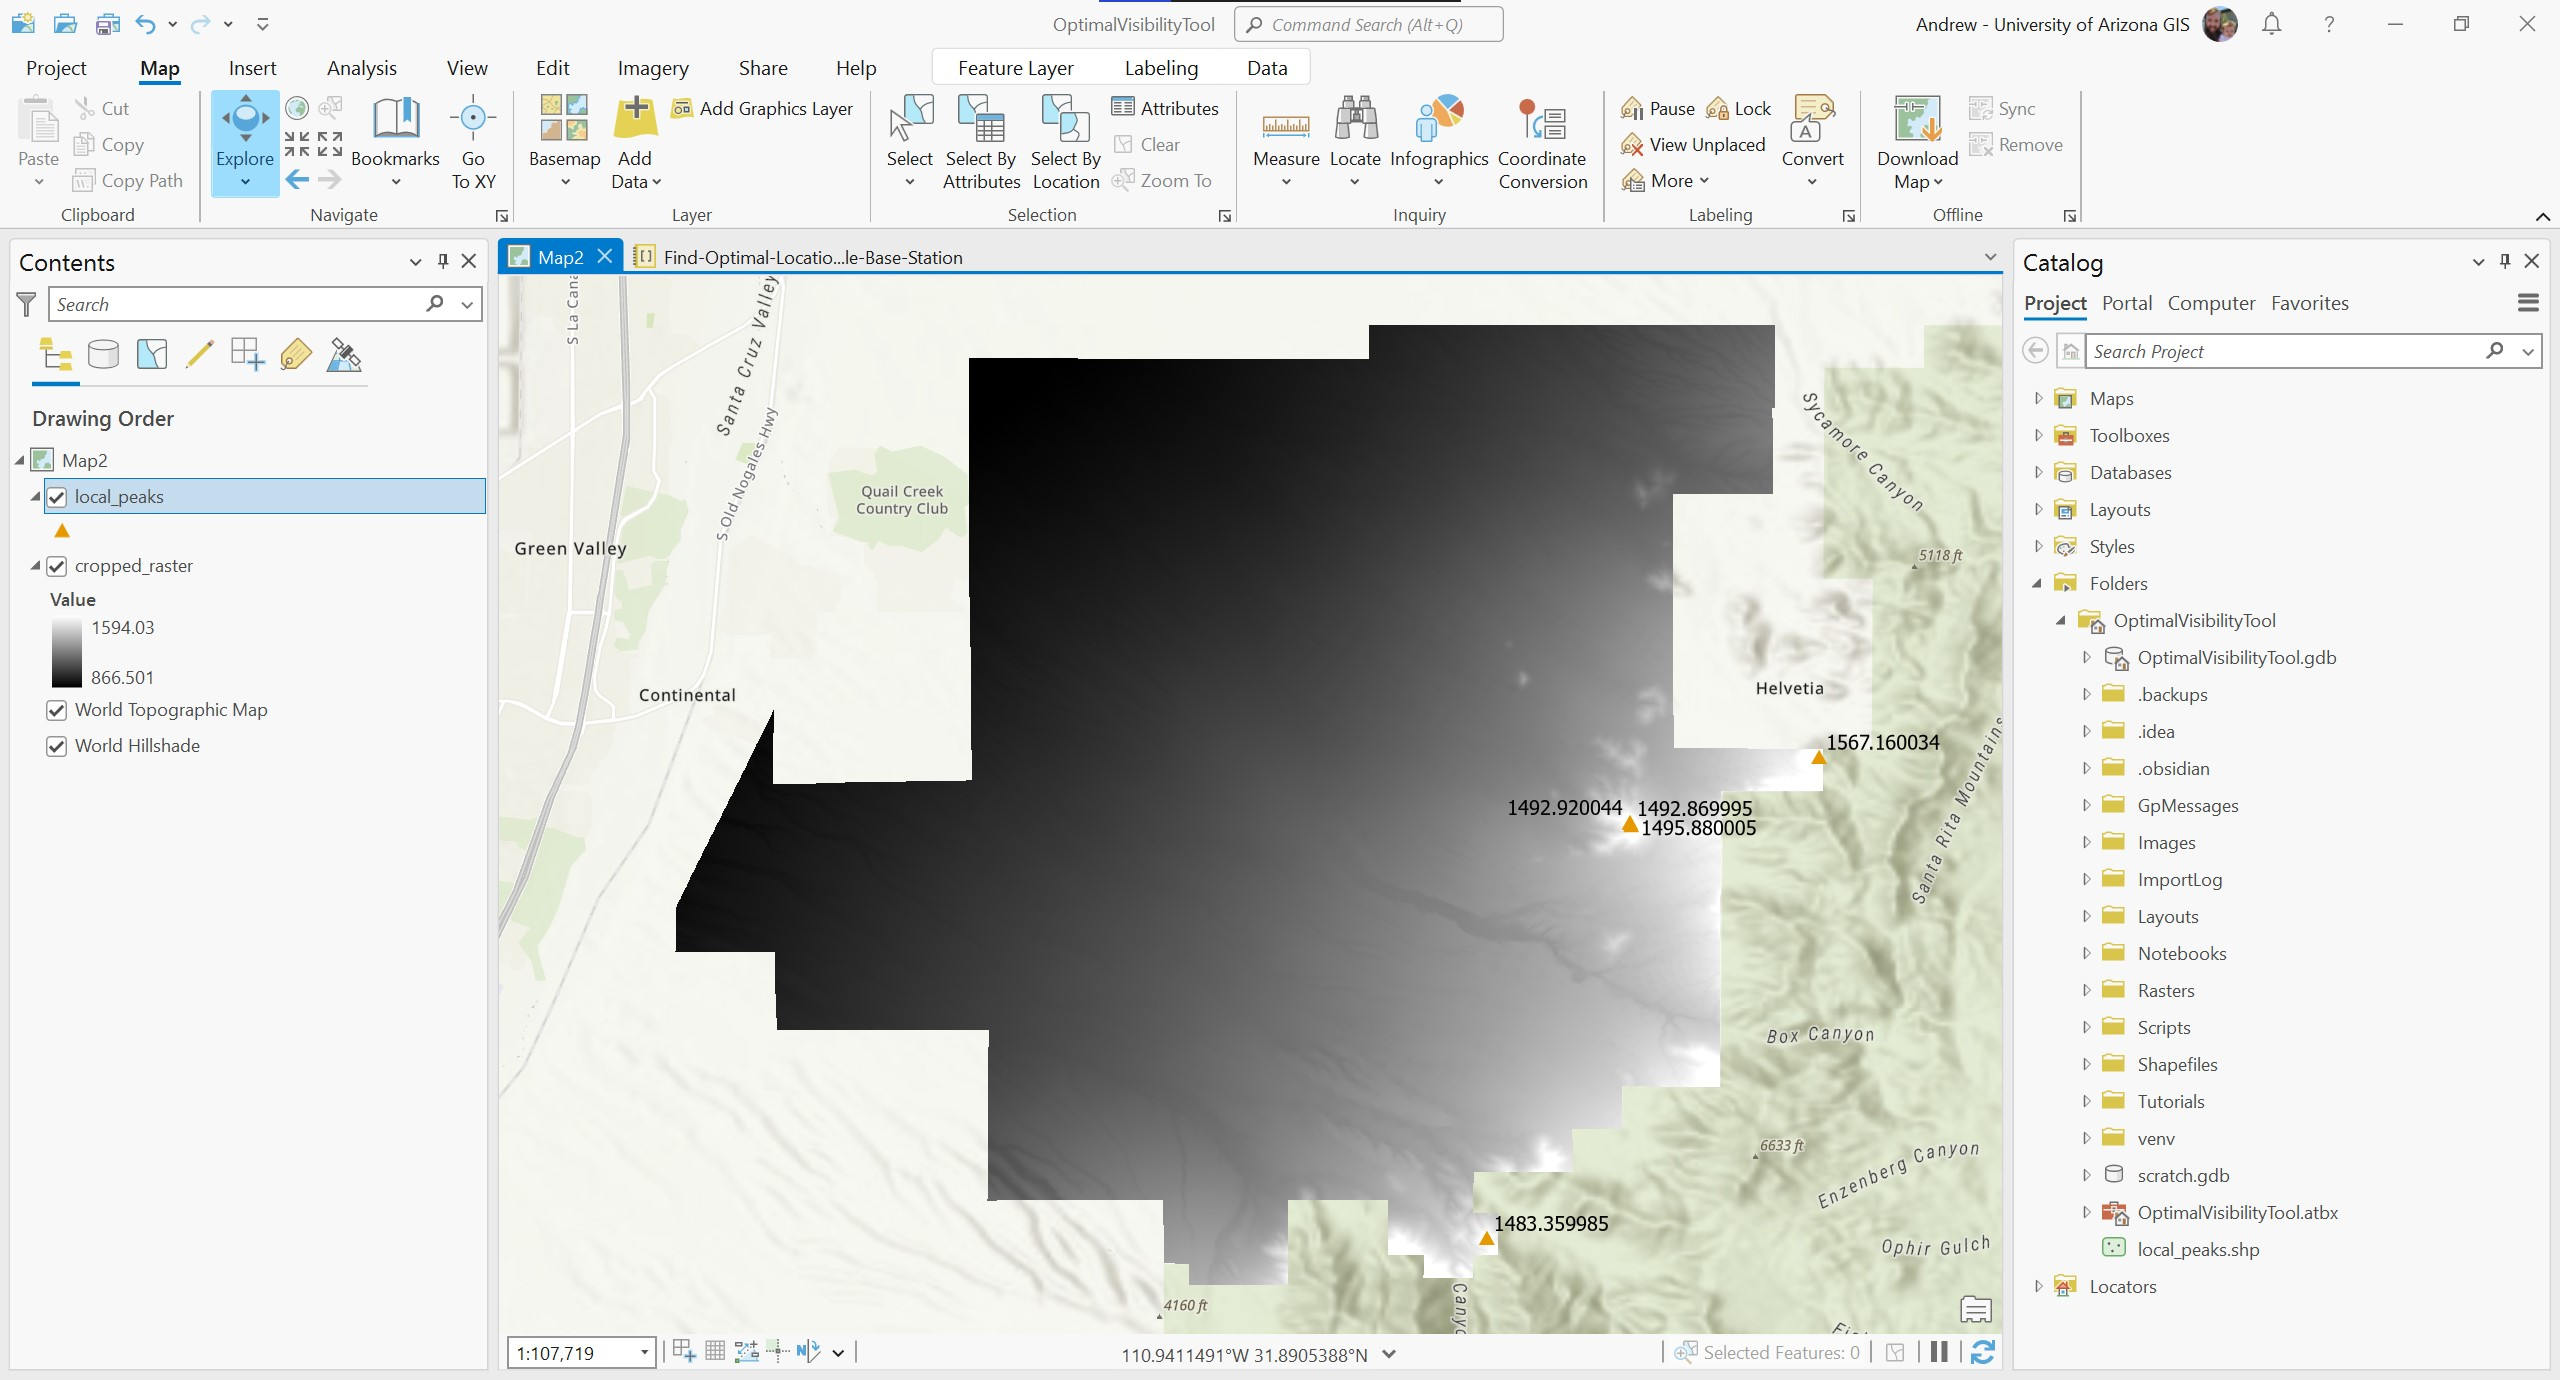

In [18]:
# Create a name for output folder for the visibility analysis 
# You can change the folder name every run to save the analysis from the previous run
# Or leave the folder name the same each run to over-write the previous run 
visibility_analysis_folder_name = "visibility_output_6"

visibility_analysis_folder_path = os.path.join(raster_folder,
                                                visibility_analysis_folder_name)
print(visibility_analysis_folder_path)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\visibility_output_6


In [19]:
# Create the new folder to contain the visibility analysis output if it doesn't already exist
if not os.path.isdir(visibility_analysis_folder_path):
    try:
        os.mkdir(visibility_analysis_folder_path)
    except OSError as error:
        print(error)

In [20]:
# Select the name of the first field/column from the local_peaks output
field = 'FID'

# List all object IDs from field = 'FID'
all_object_ids = [row[0] for row in arcpy.da.SearchCursor(local_peaks, field)]
print(all_object_ids)

# Find the object ID fieldname
object_id_field = arcpy.Describe(local_peaks).OIDFieldName
print(object_id_field)

[0, 1, 2, 3, 4]
FID


In [21]:
# Loop through each of the points from the local_peaks points
for pointid in all_object_ids:
    
    # create a where clause to select only the point with the object ID 
    sql = "{0}={1}".format(
        arcpy.AddFieldDelimiters(
            datasource=local_peaks, 
            field=object_id_field), 
        pointid)
    
    # create a layer with only this point in it
    arcpy.MakeFeatureLayer_management(
        in_features=local_peaks, 
        out_layer=f"visibility_point_{pointid}",
        where_clause=sql)
    
    # generate a viewshed from each point in the local_peaks points    
    # you can change the observer_offset value to account for the height of the antenna if needed
    # TODO use the visibility from the uncropped raster
    # as the cropped raster may be missing mountains that may block the signal
    last_visibility_output = arcpy.sa.Visibility(cropped_raster, # DEM cropped by your boundary shapefile
                                 f"visibility_point_{pointid}", # single point from the local_peaks points
                                 analysis_type="OBSERVERS", 
                                 nonvisible_cell_value="NODATA", 
                                 observer_offset=6) # observer height in meters
    
    # create a name for each visibility raster using its object ID
    # visibility_analysis_1.tif, visibility_analysis_2.tif etc...
    output_raster_name = os.path.join(visibility_analysis_folder_path,
                                      "visiblity_analysis_{0}.tif".format(pointid)
                                      )
    # save each visibility raster to .tif file
    last_visibility_output.save(output_raster_name)

In [35]:
# change the ArcPy workspace to the visibility analysis output folder
arcpy.env.workspace = visibility_analysis_folder_path

# check that workspace is correct
print(arcpy.env.workspace)

# create a list of rasters in the visibility_analysis_folder_path
rasters = arcpy.ListRasters()

# load the visibility analysis rasters into ArcGIS for visual comparison
aprx = arcpy.mp.ArcGISProject('CURRENT')
for raster in rasters:
    raster_layer = arcpy.MakeRasterLayer_management(raster, f"{raster}")

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\visibility_output_5
['visiblity_analysis_0.tif', 'visiblity_analysis_1.tif', 'visiblity_analysis_2.tif', 'visiblity_analysis_3.tif', 'visiblity_analysis_4.tif']


In [4]:
# initialize variables to keep track of the maximum count value 
# and the name of the raster with the maximum count value
# the raster with the maximum count value is the optimal base station location
max_count = -1
max_count_raster = ""

In [39]:
# change the working directory to save the CSV files in the "visibility_output_{}" folder
os.chdir(visibility_analysis_folder_path)

# Iterate through the list of rasters
for raster in rasters:
    # Create a unique filename for the output dataframe
    output_filename = f"{raster}_table.csv"

    # Get the raster attribute table as a table view
    table_view_name = f"{raster}_view"
    table_view = arcpy.MakeTableView_management(raster, table_view_name)

    # Get the Count value from each raster table using a SearchCursor
    count_field = "Count"
    with arcpy.da.SearchCursor(table_view, count_field) as cursor:
        count_values = [row[0] for row in cursor]

    # Find the maximum count value
    count_max = max(count_values)

    # Check if the Count value is greater than the current maximum count value
    if count_max > max_count:
        # If so, update the maximum count value and the name of the raster with the maximum count value
        max_count = count_max
        max_count_raster = raster

    # Convert the table view to a Pandas dataframe
    dataframe = pd.DataFrame.from_records(arcpy.da.TableToNumPyArray(table_view, count_field))

    # Save the dataframe to a file
    dataframe.to_csv(output_filename, index=False)

    # Print a message indicating the dataframe has been saved
    print(f"{output_filename} saved successfully.")

visiblity_analysis_0.tif_table.csv saved successfully.
visiblity_analysis_1.tif_table.csv saved successfully.
visiblity_analysis_2.tif_table.csv saved successfully.
visiblity_analysis_3.tif_table.csv saved successfully.
visiblity_analysis_4.tif_table.csv saved successfully.


In [40]:
# Print the name of the raster with the maximum count value
# The count value represents the number of raster cells that the point has visibility of
print(f"Raster with the highest visibility is {max_count_raster} with a count of {max_count}")
# You can find this raster in your specified output folder.
# The raster number corresponds with the point number

Raster with the highest visibility is visiblity_analysis_2.tif with a count of 2118807.0


After successfully running your script, you should get an output that will tell you the raster that has the highest visibility, as well as the number of raster cells that are visible from that point. This is the 'optimal' location to place the virtual fence base station. However, practical limitations such as distance from roads and terrain may affect the actual placement of the base station.

To view approximate radio coverage from each point, first un-check all of the checkboxes next to each point and raster layer.

